# Set-up

In [16]:
# Importing libraries
import os
import glob
import json
import random

import numpy as np
import pandas as pd
import pyBigWig

import matplotlib.pyplot as plt
import seaborn as sns

def plot_tracks(tracks, interval, height=1.5, colors=None, sharey=False):
  _, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True, sharey=sharey)
  if not isinstance(axes, np.ndarray):
    axes = [axes]
  for ax, (title, y) in zip(axes, tracks.items()):
    if colors is not None:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y, color=colors[title])
    else:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(f"{interval['chrom']}:{interval['start']}-{interval['end']}")
  plt.tight_layout()

def plot_tracks_from_locus(locus, bws, colors, sharey=False):
    chrom, coord = locus.split(":")
    start, end = coord.split("-")
    start, end = int(start), int(end)
    interval = {"chrom": chrom, "start": int(start), "end": int(end)}
    tracks = {k: np.nan_to_num(np.array(bw.values(chrom, start, end))) for k, bw in bws.items()}
    plot_tracks(tracks, interval, height=1.5, colors=colors, sharey=sharey)

In [27]:
color_dict = {
    # D4 - early differentiation (deep teal to green)
    'D4_DE_LEFTY1+': '#1b9e77',
    'D4_DE_POLG2+': '#23a983',
    'D4_DE_MitoHi': '#2db27d',
    'D4_DE_ONECUT2+': '#37b878',
    'D4_DE_ERBB4+': '#42be71',
    'D4_DE_CDH8+': '#4ac16d',
    'D4_DE_SOX4+': '#54c568',

    # D7 - gut tube (blue-green to blue)
    'D7_DE_SOX17+': '#26828e',
    'D7_GT_ONECUT1+': '#297a8e',
    'D7_FLT1+': '#2e6f8e',
    'D7_NECTIN3-AS1+': '#32648e',
    'D7_GT_CXCR4+': '#38588c',
    'D7_GT_POLG2': '#3f4889',
    'D7_GT_proliferating': '#46327e',
    'D7_liver': '#481f70',

    # D9 - posterior foregut (purple–magenta tones)
    'D9_ENP': '#6a51a3',
    'D9_NECTIN3-AS1+': '#8073ac',
    'D9_LINC01924+': '#9272b4',
    'D9_DE_OTX2+': '#9e9ac8',
    'D9_PFG_PLOG2+': '#bcbddc',
    'D9_PFG_proliferating': '#dadaeb',
    'D9_PFG_TTR+': '#efedf5',
    'D9_PFG_CREB5+': '#b3cde3',
    'D9_PFG_NRG3+': '#8c96c6',
    'D9_PFG_CDH18+': '#756bb1',
    'D9_liver': '#54278f',

    # D12 - pancreatic progenitors (warm oranges)
    'D12_PP_ENP': '#fdae61',
    'D12_ENP_ARX+': '#fdb863',
    'D12_liver': '#fdd49e',
    'D12_ENP_SCG2+': '#f6e8c3',
    'D12_PP_ERBB4+': '#fee08b',
    'D12_ENP_OCA2+': '#e6f598',
    'D12_PP_CREB5+': '#abdda4',
    'D12_pre_EC_beta': '#66c2a5',

    # D15 - pre-endocrine (gold to red-orange)
    'D15_pre_EC': '#f46d43',
    'D15_pre_delta': '#fdae61',
    'D15_FLT1+': '#fee08b',
    'D15_PP_ERBB4+': '#e6f598',
    'D15_PP_CREB5+': '#abdda4',
    'D15_PP_ENP': '#66c2a5',
    'D15_pre_alpha': '#3288bd',
    'D15_pre_beta': '#5e4fa2',
    'D15_pre_EC_beta': '#9e0142',
    'D15_ENP_OCA2+': '#9e0142',
    'D15_liver': '#f4a582',

    # D22 - late progenitors / secondary transition (green-yellow-blue)
    'D22_late_ENP': '#7fc97f',
    'D22_late_SC_EC': '#beaed4',
    'D22_late_SC_EC_beta': '#fdc086',
    'D22_late_others': '#ffff99',
    'D22_ENP_OCA2+': '#386cb0',
    'D22_pre_alpha': '#f0027f',
    'D22_SC_EC': '#bf5b17',
    'D22_SC_EC_beta': '#666666',
    'D22_SC_alpha': '#a6d854',
    'D22_SC_beta': '#ffd92f',
    'D22_SC_delta+': '#e78ac3',
    'D22_PP_ERBB4+': '#8da0cb',
    'D22_liver': '#fc8d62',
    'D22_late_SC_alpha': '#66c2a5',
    'D22_late_SC_beta': '#fc8d62',

    # D45 - mature endocrine (β, α, δ, EC; vivid palette)
    'D45_SC_beta': '#1f77b4',
    'D45_SC_alpha1': '#ff7f0e',
    'D45_SC_alpha2': '#ffbb78',
    'D45_SC_delta': '#2ca02c',
    'D45_SC_EC': '#d62728',
    'D45_SC_EC_beta': '#9467bd',
    'D45_ENP_EC': '#8c564b',
    'D45_HSPA6+': '#e377c2',
    'D45_early_SC_alpha': '#7f7f7f',
    'D45_early_SC_beta': '#bcbd22',
    'D45_early_SC_EC': '#17becf',
    'D45_early_SC_EC_beta': '#aec7e8',
    'D45_early_others': '#c5b0d5',
    'D45_liver': '#ff9896',
}

In [22]:
# Paths
path_fragments_counts = "/cellar/users/aklie/data/datasets/sc-islet-differentiation_10X-Multiome/fragments/fragment_counts.tsv"
path_narrowPeaks_dir = "/cellar/users/aklie/data/datasets/sc-islet-differentiation_10X-Multiome/peaks"
path_out = "/cellar/users/aklie/data/datasets/sc-islet-differentiation_10X-Multiome/models"

os.makedirs(path_out + "/summary", exist_ok=True)

# Data overview

In [19]:
%%bash
set -euo pipefail

# Input and output paths
path_in="/cellar/users/aklie/data/datasets/sc-islet-differentiation_10X-Multiome/fragments"
path_out="/cellar/users/aklie/data/datasets/sc-islet-differentiation_10X-Multiome/fragments/fragment_counts.tsv"

# Check if output file already exists
if [ ! -f "$path_out" ]; then

    # Write header
    echo -e "celltype\tnum_fragments" > "$path_out"

    # Loop through all merged sorted fragment files
    for file in "$path_in"/*/merged_fragments_*_sorted.tsv; do
        # Extract cell type from filename
        celltype=$(basename "$file" | sed -E 's/^merged_fragments_//; s/_sorted.tsv$//')
        
        # Count lines (number of fragments)
        num_fragments=$(wc -l < "$file")
        
        echo -e "${celltype}\t${num_fragments}" >> "$path_out"
    done

    echo "✅ Written fragment counts to: $path_out"
else
    echo "⚠️ File already exists: $path_out"
fi

✅ Written fragment counts to: /cellar/users/aklie/data/datasets/sc-islet-differentiation_10X-Multiome/fragments/fragment_counts.tsv


In [20]:
# Load fragment counts to start
fragment_counts = pd.read_csv(path_fragments_counts, sep="\t", index_col=0)["num_fragments"].to_dict()

# Get number of narrowPeaks per celltype
narrowPeaks = {}
for f in glob.glob(f"{path_narrowPeaks_dir}/*/*_peaks.bed"):
    celltype = os.path.basename(f).split("_peaks.bed")[0]
    if celltype in ["D15_ENP", "D15_rep1_ENP", "D15_rep2_ENP"]:
        continue
    narrowPeaks[celltype] = len(pd.read_csv(f, sep="\t", header=None))

# Make a df that looks like this: Cell Type	Number of Barcodes	Number of Fragments	Number of Peak Calls
df = pd.DataFrame({
    "Number of Fragments": pd.Series(fragment_counts),
    "Number of Peak Calls": pd.Series(narrowPeaks)
})
df.index.name = "Cell Type"
df = df.sort_index(key=lambda x: x.str.lower())

# Save
df.to_csv(f"{path_out}/summary/data_overview.csv")

# Check
df

,Number of Fragments,Number of Peak Calls
Cell Type,,
D12_ENP_ARX+,3211546.0,75907
D12_ENP_OCA2+,7081852.0,102049
D12_ENP_SCG2+,25707716.0,163558
D12_liver,2198939.0,75173
D12_PP_CREB5+,64584049.0,209679
...,...,...
D9_PFG_CREB5+,17919361.0,142649
D9_PFG_NRG3+,133789222.0,318881
D9_PFG_PLOG2+,9649462.0,109568


# Bias model overview

In [ ]:
# Count up negatives used for each celltype and fold
negatives = {}
for f in glob.glob(f"{path_out}/*/fold_*/negatives/*.bed"):
    celltype = os.path.basename(f).split("_negatives.bed")[0]
    fold = f.split("/")[-3]
    if celltype not in negatives:
        negatives[celltype] = {}
    negatives[celltype][fold] = len(pd.read_csv(f, sep="\t", header=None))

# Turn into long form with celltype, fold, and count
negatives_df = pd.DataFrame(negatives).T.reset_index().melt(id_vars="index", var_name="fold", value_name="Number of Negatives")
negatives_df.columns = ["Cell Type", "Fold", "Number of Negatives"]
negatives_df = negatives_df.sort_values("Cell Type", key=lambda x: x.str.lower())

# Find all data parameters
bias_data_params = pd.DataFrame()
for f in glob.glob(f"{path_out}/*/*/bias_model/*/logs/bias_data_params.tsv"):
    celltype = f.split("/")[-6]
    fold = f.split("/")[-5]
    beta = f.split("/")[-3]
    curr_df = pd.read_csv(f, sep="\t", index_col=0, header=None).T
    curr_df["celltype"] = celltype
    curr_df["beta"] = beta
    curr_df["fold"] = fold
    bias_data_params = bias_data_params.append(curr_df)

# Find all jsons with performance metrics
bias_metrics = pd.DataFrame()
for f in glob.glob(f"{path_out}/*/*/bias_model/*/evaluation/bias_metrics.json"):
    celltype = f.split("/")[-6]
    fold = f.split("/")[-5]
    beta = f.split("/")[-3]
    with open(f, "r") as f:
        curr_dict = json.load(f)
    curr_dict = {f"{k1}_{k2}_{k3}": v3 for k1, v1 in curr_dict.items() for k2, v2 in v1.items() for k3, v3 in v2.items()}
    curr_df = pd.DataFrame(curr_dict, index=[0])
    curr_df["celltype"] = celltype
    curr_df["beta"] = beta
    curr_df["fold"] = fold
    bias_metrics = bias_metrics.append(curr_df)

# Merge dfs
bias = bias_data_params.merge(bias_metrics, on=["celltype", "beta", "fold"])
bias = bias.merge(negatives_df, left_on=["celltype", "fold"], right_on=["Cell Type", "Fold"])

# Clean up dataframe
bias_clean = bias[["celltype", "beta", "fold", "Number of Negatives", "counts_metrics_nonpeaks_pearsonr", "counts_metrics_peaks_pearsonr", "profile_metrics_nonpeaks_median_jsd", "profile_metrics_peaks_median_jsd"]]
bias_clean.columns = ["Cell Type", "Beta", "Fold", "Number of Negatives", "Bias Model Pearson r in Non-Peaks", "Bias Model Pearson r in Peaks", "Bias Model JSD in Non-Peaks", "Bias Model JSD in Peaks"]
bias_clean["lower_celltype"] = bias_clean["Cell Type"].str.lower()
bias_clean = bias_clean.sort_values(["lower_celltype", "Beta", "Fold"])
bias_clean["Number of Negatives"] = bias_clean["Number of Negatives"].astype(int)
bias_clean["Bias Model Pearson r in Non-Peaks"] = bias_clean["Bias Model Pearson r in Non-Peaks"].round(2)
bias_clean["Bias Model Pearson r in Peaks"] = bias_clean["Bias Model Pearson r in Peaks"].round(2)
bias_clean["Bias Model JSD in Non-Peaks"] = bias_clean["Bias Model JSD in Non-Peaks"].round(2)
bias_clean["Bias Model JSD in Peaks"] = bias_clean["Bias Model JSD in Peaks"].round(2)
bias_clean = bias_clean.drop(columns="lower_celltype")

# Save
bias_clean.to_csv(f"{path_out}/summary/bias_metrics.csv", index=False)

# Check it
bias_clean.head()

/tmp/ipykernel_630774/1143351321.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_data_params = bias_data_params.append(curr_df)
/tmp/ipykernel_630774/1143351321.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_data_params = bias_data_params.append(curr_df)
/tmp/ipykernel_630774/1143351321.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_data_params = bias_data_params.append(curr_df)
/tmp/ipykernel_630774/1143351321.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bias_data_params = bias_data_params.append(curr_df)
/tmp/ipykernel_630774/1143351321.py:25: FutureWarning: The frame.append method is deprecated

,Cell Type,Beta,Fold,Number of Negatives,Bias Model Pearson r in Non-Peaks,Bias Model Pearson r in Peaks,Bias Model JSD in Non-Peaks,Bias Model JSD in Peaks
69,D12_ENP_ARX+,0.5,fold_0,135882,0.18,0.28,0.81,0.73
59,D12_ENP_OCA2+,0.5,fold_0,182658,0.40,0.49,0.81,0.71
15,D12_ENP_SCG2+,0.5,fold_0,293123,0.49,0.49,0.78,0.63
51,D12_liver,0.5,fold_0,134174,0.20,0.42,0.82,0.76
38,D12_PP_CREB5+,0.5,fold_0,374286,0.51,0.10,0.74,0.58


In [38]:
# which keys in color_dict are missing from bias_clean["Cell Type"]?
set(color_dict.keys()) - set(bias_clean["Cell Type"].unique())

{'D7_FLT1+', 'D7_GT_ONECUT1+', 'D9_PFG_NRG3+'}

# ChromBPNet model overview

In [47]:
# Same for full model
model_params = pd.DataFrame()
for f in glob.glob(f"{path_out}/*/*/chrombpnet/*/logs/*_model_params.tsv"):
    celltype = f.split("/")[-6]
    fold = f.split("/")[-5]
    beta = f.split("/")[-3]
    curr_df = pd.read_csv(f, sep="\t", index_col=0, header=None).T
    curr_df["celltype"] = celltype
    curr_df["beta"] = beta
    curr_df["fold"] = fold
    model_params = model_params.append(curr_df)

# Metrics
model_metrics = pd.DataFrame()
for f in glob.glob(f"{path_out}/*/*/chrombpnet/*/evaluation/chrombpnet_metrics.json"):
    celltype = f.split("/")[-6]
    fold = f.split("/")[-5]
    beta = f.split("/")[-3]
    with open(f, "r") as f:
        curr_dict = json.load(f)
    curr_dict = {f"{k1}_{k2}_{k3}": v3 for k1, v1 in curr_dict.items() for k2, v2 in v1.items() for k3, v3 in v2.items()}
    curr_df = pd.DataFrame(curr_dict, index=[0])
    curr_df["celltype"] = celltype
    curr_df["beta"] = beta
    curr_df["fold"] = fold
    model_metrics = model_metrics.append(curr_df)

# merge model_params and model_metrics
model = model_params.merge(model_metrics, on=["celltype", "beta", "fold"])

# Clean up dataframe
model_clean = model[["celltype", "beta", "fold", "counts_metrics_peaks_pearsonr", "profile_metrics_peaks_median_jsd"]]
model_clean.columns = ["Cell Type", "Beta", "Fold", "ChromBPNet Pearson r in Peaks", "ChromBPNet Median JSD in Peaks"]
model_clean["lower_celltype"] = model_clean["Cell Type"].str.lower()
model_clean = model_clean.sort_values(["lower_celltype", "Beta", "Fold"])
model_clean = model_clean.drop(columns="lower_celltype")
model_clean["ChromBPNet Pearson r in Peaks"] = model_clean["ChromBPNet Pearson r in Peaks"].round(3)
model_clean["ChromBPNet Median JSD in Peaks"] = model_clean["ChromBPNet Median JSD in Peaks"].round(3)

# Save
model_clean.to_csv(f"{path_out}/summary/model_metrics.csv", index=False)

# Check it
model_clean.head()

/tmp/ipykernel_630774/674878171.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_params = model_params.append(curr_df)
/tmp/ipykernel_630774/674878171.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_params = model_params.append(curr_df)
/tmp/ipykernel_630774/674878171.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_params = model_params.append(curr_df)
/tmp/ipykernel_630774/674878171.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_params = model_params.append(curr_df)
/tmp/ipykernel_630774/674878171.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

,Cell Type,Beta,Fold,ChromBPNet Pearson r in Peaks,ChromBPNet Median JSD in Peaks
70,D12_ENP_ARX+,0.5,fold_0,0.824,0.680
60,D12_ENP_OCA2+,0.5,fold_0,0.858,0.657
16,D12_ENP_SCG2+,0.5,fold_0,0.827,0.577
52,D12_liver,0.5,fold_0,0.832,0.723
39,D12_PP_CREB5+,0.5,fold_0,0.833,0.531


In [48]:
# which keys in color_dict are missing from model_clean["Cell Type"]?
set(color_dict.keys()) - set(model_clean["Cell Type"].unique())

{'D7_FLT1+', 'D7_GT_ONECUT1+', 'D9_PFG_NRG3+'}

# Plot

In [49]:
# Merge df and bias_clean
model_clean = model_clean.merge(df, how="left", left_on="Cell Type", right_index=True)
model_clean = model_clean.merge(bias_clean, how="left", on=["Cell Type", "Beta", "Fold"])

# remove D15_ENP from the table
model_clean = model_clean[model_clean["Cell Type"] != "D15_ENP"]

# Sort by color_dict keys
model_clean["color_order"] = model_clean["Cell Type"].map(lambda x: list(color_dict.keys()).index(x))
model_clean = model_clean.sort_values("color_order")

model_clean.head()

,Cell Type,Beta,Fold,ChromBPNet Pearson r in Peaks,ChromBPNet Median JSD in Peaks,Number of Fragments,Number of Peak Calls,Number of Negatives,Bias Model Pearson r in Non-Peaks,Bias Model Pearson r in Peaks,Bias Model JSD in Non-Peaks,Bias Model JSD in Peaks,color_order
51,D4_DE_LEFTY1+,0.5,fold_0,0.835,0.707,4548869.0,88311.0,157587.0,0.40,0.53,0.81,0.73,0
54,D4_DE_POLG2+,0.5,fold_0,0.846,0.636,15647712.0,139888.0,249651.0,0.51,0.48,0.78,0.67,1
52,D4_DE_MitoHi,0.5,fold_0,0.864,0.645,15265862.0,133100.0,237447.0,0.50,0.43,0.78,0.68,2
53,D4_DE_ONECUT2+,0.5,fold_0,0.850,0.676,7485909.0,114708.0,204821.0,0.48,0.49,0.80,0.71,3
50,D4_DE_ERBB4+,0.5,fold_0,0.862,0.573,59354377.0,268469.0,479069.0,0.29,-0.49,0.72,0.60,4


/tmp/ipykernel_630774/1499082966.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Number of Fragments", y="Cell Type", data=model_clean, ax=axs[0], orient="h", palette=color_dict)
/tmp/ipykernel_630774/1499082966.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Number of Peak Calls", y="Cell Type", data=model_clean, ax=axs[1], orient="h", palette=color_dict)
/tmp/ipykernel_630774/1499082966.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ChromBPNet Pearson r in Peaks", y="Cell Type", data=model_clean, ax=axs[2], orient="

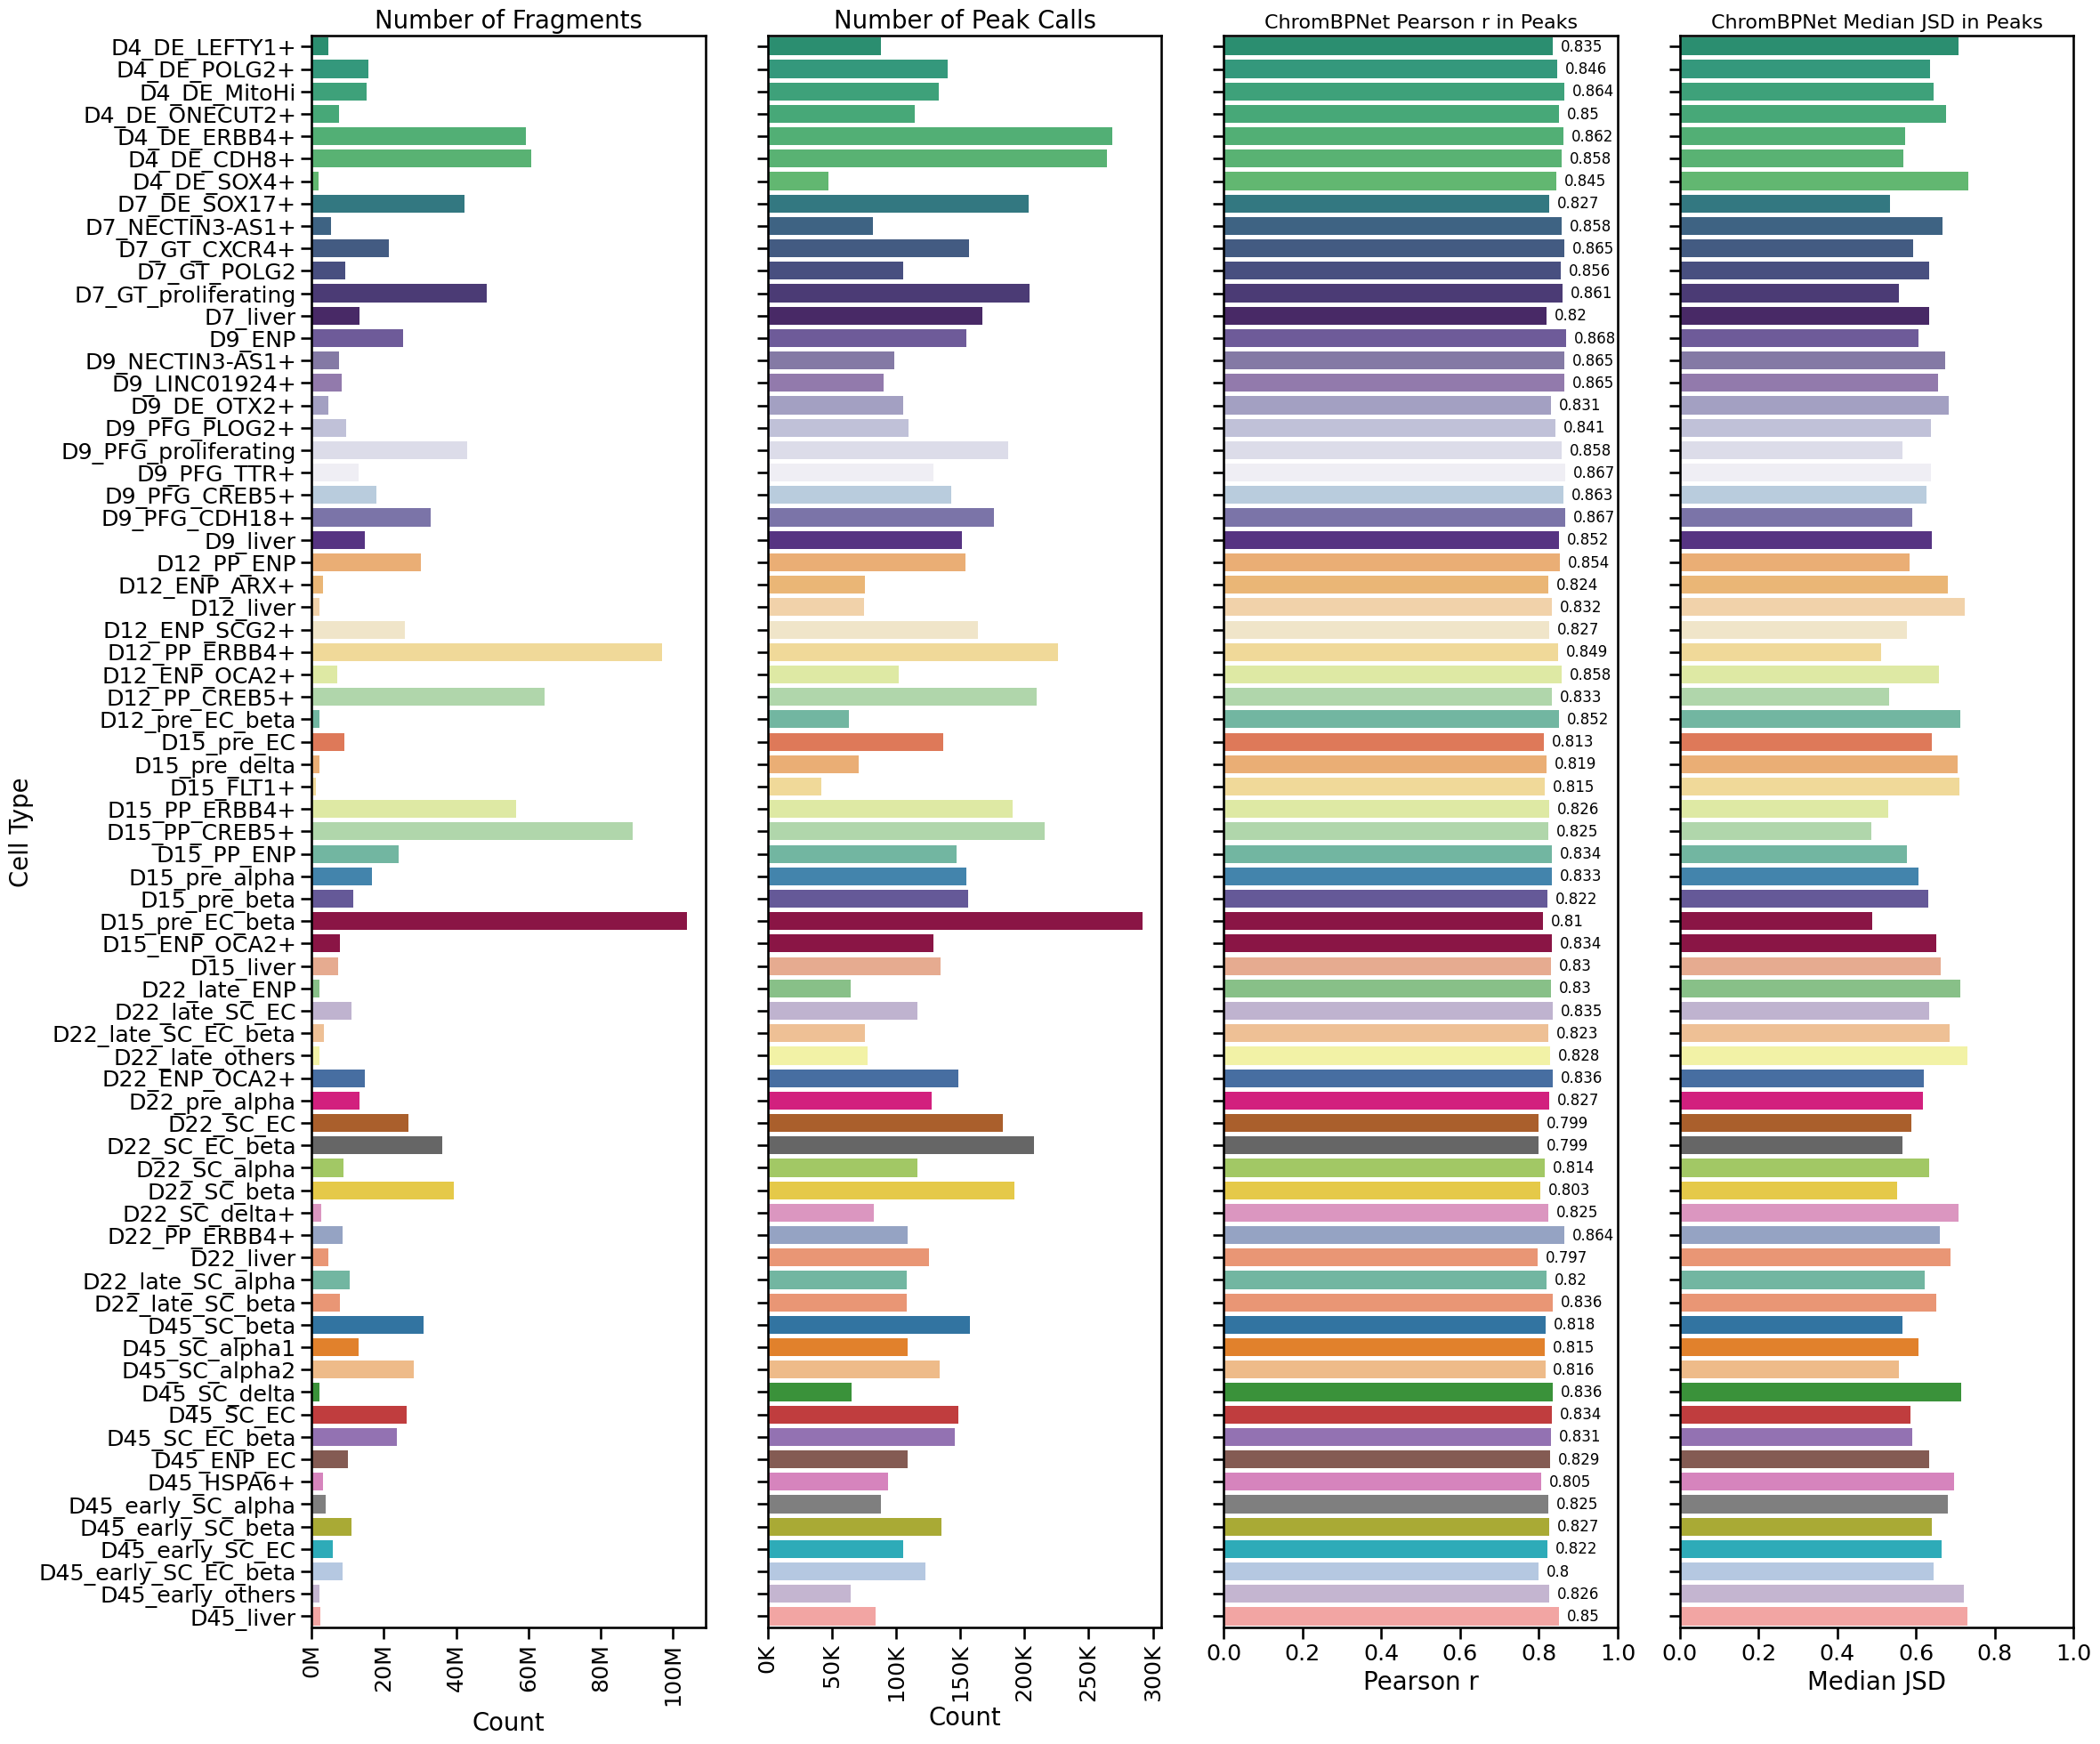

In [50]:
with sns.plotting_context("talk", font_scale=1.1):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 20), sharey=True)

    # Plot number of fragments
    sns.barplot(x="Number of Fragments", y="Cell Type", data=model_clean, ax=axs[0], orient="h", palette=color_dict)
    axs[0].set_title("Number of Fragments")
    axs[0].set_xlabel("Count")
    # format xticklabels as Millions and rotate
    axs[0].get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x/1e6):d}M"))
    axs[0].tick_params(axis='x', rotation=90)

    # Plot number of peak calls
    sns.barplot(x="Number of Peak Calls", y="Cell Type", data=model_clean, ax=axs[1], orient="h", palette=color_dict)
    axs[1].set_title("Number of Peak Calls")
    axs[1].set_xlabel("Count")
    axs[1].get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x/1e3):d}K"))
    axs[1].tick_params(axis='x', rotation=90)

    # Now do the Pearson r in Peaks
    sns.barplot(x="ChromBPNet Pearson r in Peaks", y="Cell Type", data=model_clean, ax=axs[2], orient="h", palette=color_dict)
    axs[2].set_title("ChromBPNet Pearson r in Peaks", fontsize=16)
    axs[2].set_xlabel("Pearson r")
    axs[2].set_xlim(0, 1)
    # Put the value at the end of each bar
    for i, v in enumerate(model_clean["ChromBPNet Pearson r in Peaks"]):
        axs[2].text(v + 0.02, i, str(v), color='black', va='center', fontsize=12)
    
    # Now do the Median JSD in Peaks
    sns.barplot(x="ChromBPNet Median JSD in Peaks", y="Cell Type", data=model_clean, ax=axs[3], orient="h", palette=color_dict)
    axs[3].set_title("ChromBPNet Median JSD in Peaks", fontsize=16)
    axs[3].set_xlabel("Median JSD")
    axs[3].set_xlim(0, 1)

    plt.tight_layout()

/tmp/ipykernel_630774/3479439086.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Number of Negatives", y="Cell Type", data=model_clean, ax=axs[0], orient="h", palette=color_dict)
/tmp/ipykernel_630774/3479439086.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Bias Model Pearson r in Non-Peaks", y="Cell Type", data=model_clean, ax=axs[1], orient="h", palette=color_dict)
/tmp/ipykernel_630774/3479439086.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Bias Model Pearson r in Peaks", y="Cell Type", data=model_clean, ax=axs

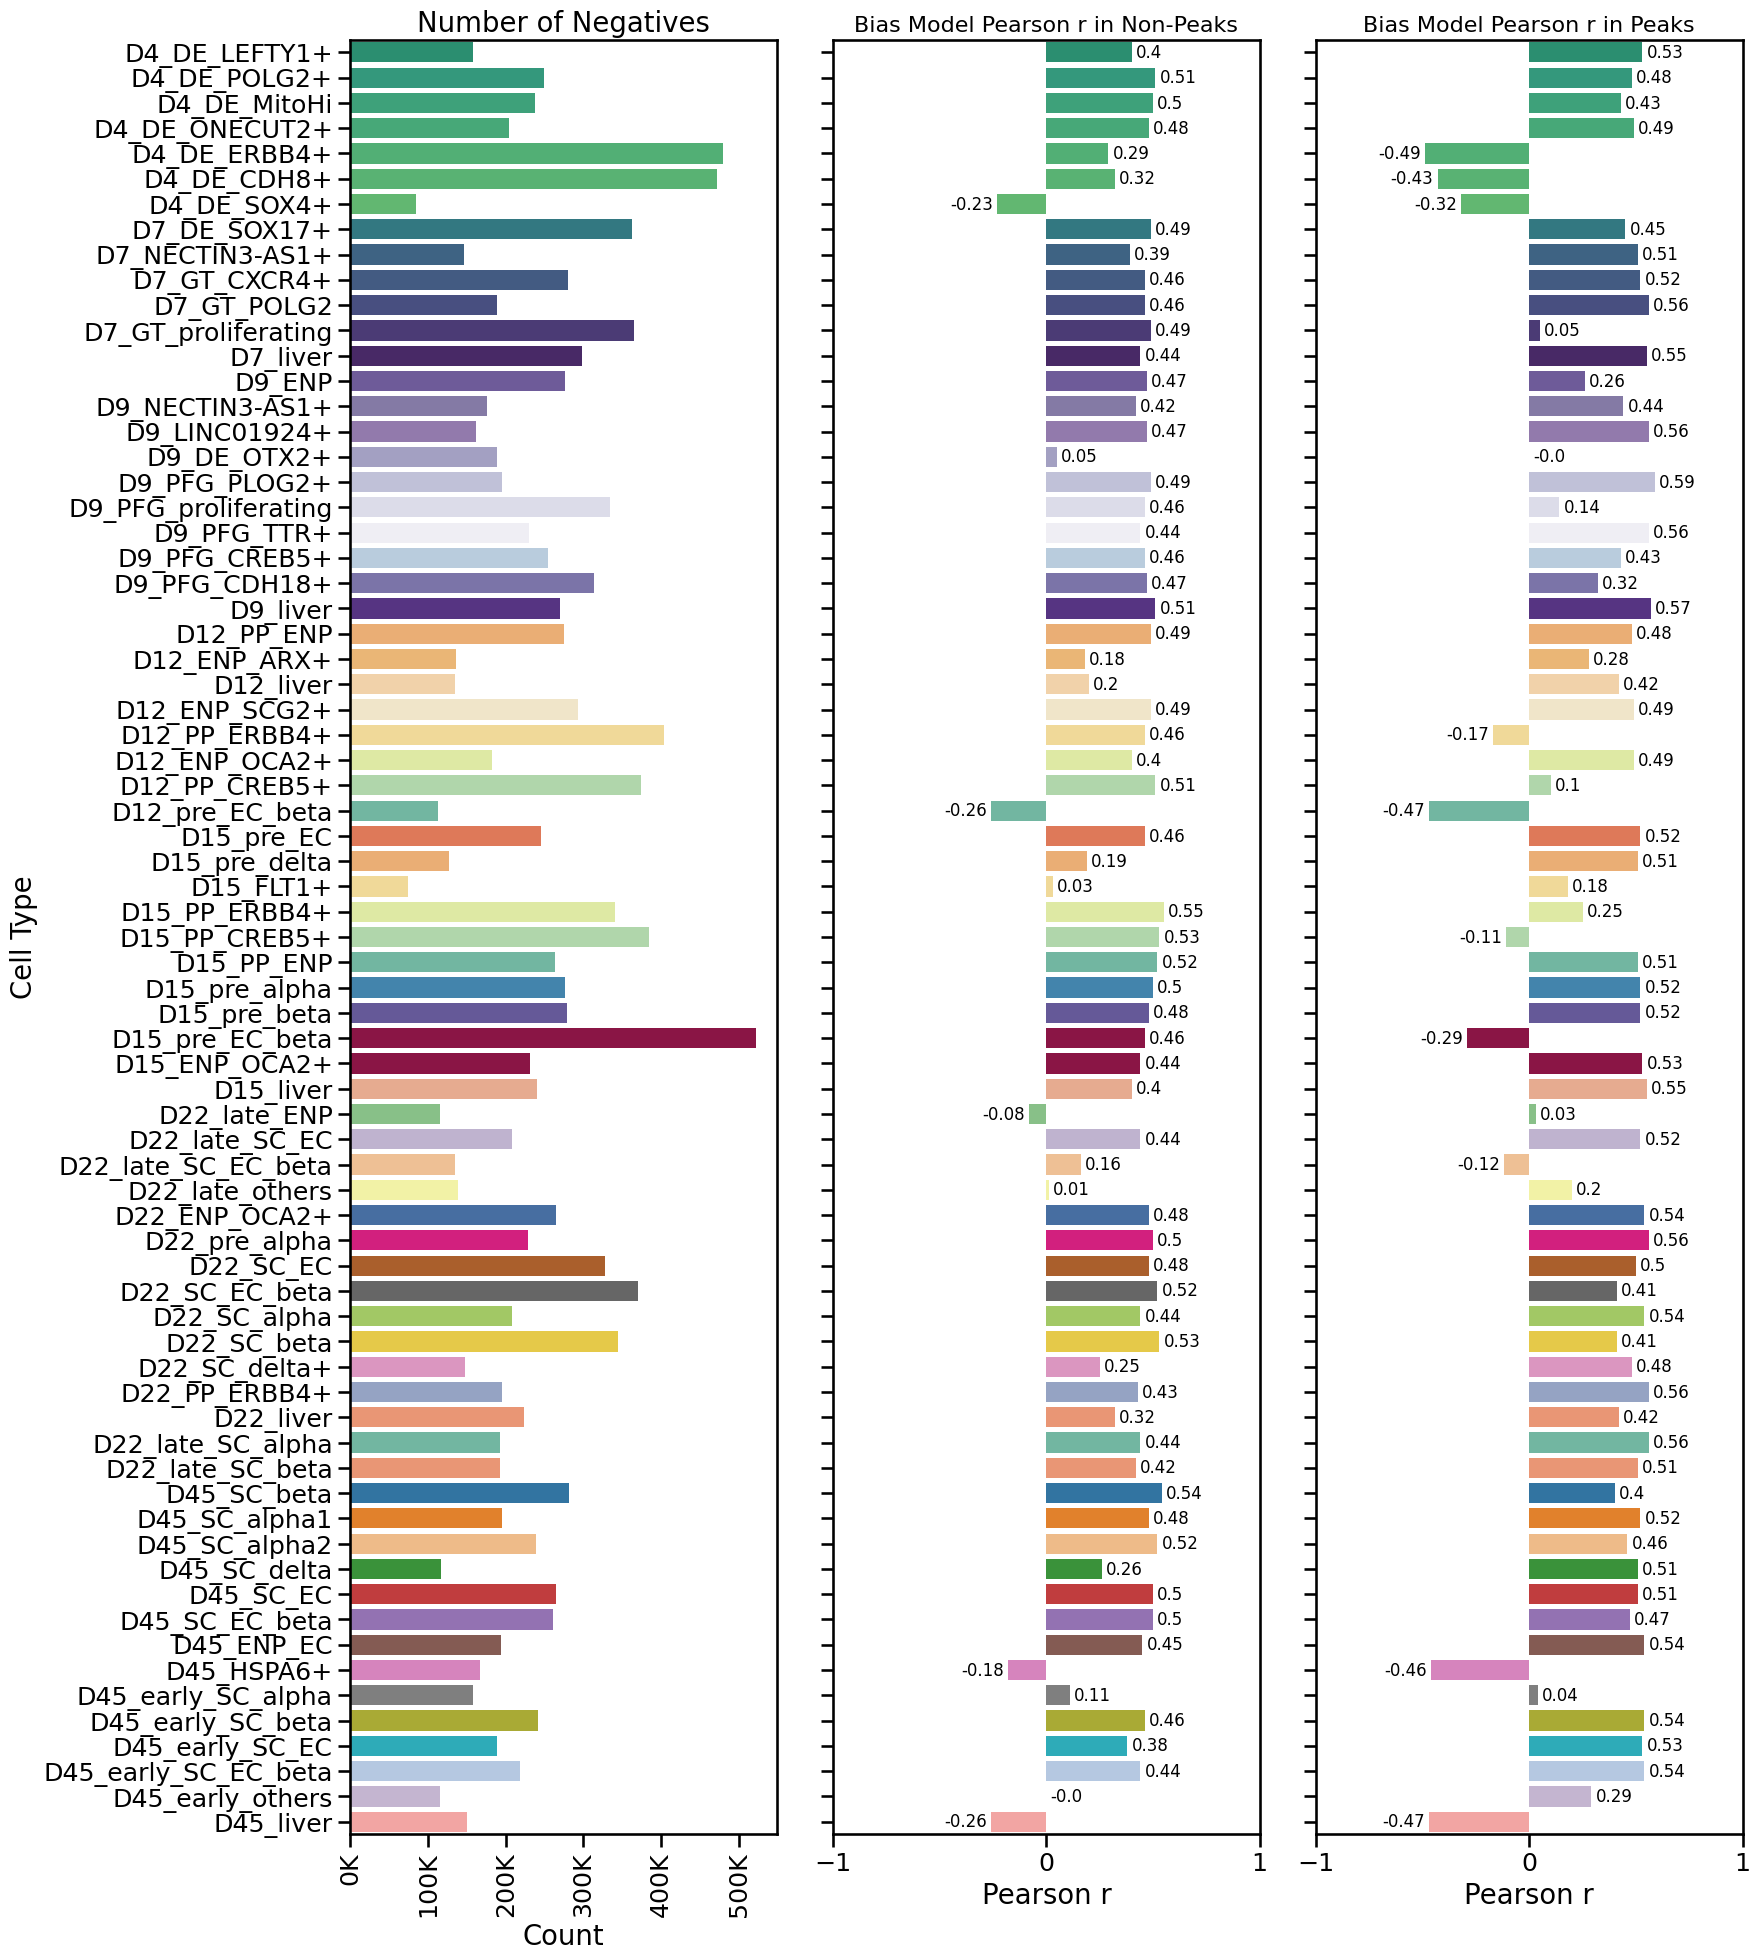

In [60]:
# Plot Number of Negatives	Bias Model Pearson r in Non-Peaks Bias Model Pearson r in Peaks from model_clean in same style

with sns.plotting_context("talk", font_scale=1.1):

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 20), sharey=True)

    # Plot number of negatives
    sns.barplot(x="Number of Negatives", y="Cell Type", data=model_clean, ax=axs[0], orient="h", palette=color_dict)
    axs[0].set_title("Number of Negatives")
    axs[0].set_xlabel("Count")
    axs[0].get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x/1e3):d}K"))
    axs[0].tick_params(axis='x', rotation=90)

    # Plot Bias Model Pearson r in Non-Peaks   
    sns.barplot(x="Bias Model Pearson r in Non-Peaks", y="Cell Type", data=model_clean, ax=axs[1], orient="h", palette=color_dict)
    axs[1].set_title("Bias Model Pearson r in Non-Peaks", fontsize=16)
    axs[1].set_xlabel("Pearson r")
    axs[1].set_xlim(-1, 1)
    for i, v in enumerate(model_clean["Bias Model Pearson r in Non-Peaks"]):
        if v >= 0:
            axs[1].text(v + 0.02, i, str(v), color='black', va='center', fontsize=12)
        else:
            axs[1].text(v - 0.22, i, str(v), color='black', va='center', fontsize=12)
    axs[1].set_xticks([-1, 0, 1])

    # Plot Bias Model Pearson r in Peaks
    sns.barplot(x="Bias Model Pearson r in Peaks", y="Cell Type", data=model_clean, ax=axs[2], orient="h", palette=color_dict)
    axs[2].set_title("Bias Model Pearson r in Peaks", fontsize=16)
    axs[2].set_xlabel("Pearson r")
    axs[2].set_xlim(-1, 1)
    for i, v in enumerate(model_clean["Bias Model Pearson r in Peaks"]):
        if v >= 0:
            axs[2].text(v + 0.02, i, str(v), color='black', va='center', fontsize=12)
        else:
            axs[2].text(v - 0.22, i, str(v), color='black', va='center', fontsize=12)
    axs[2].set_xticks([-1, 0, 1])

    plt.tight_layout()


# Predictions

In [61]:
# Get all the /cellar/users/aklie/data/datasets/sc-islet-differentiation_10X-Multiome/models/D4_DE_CDH8+/fold_0/chrombpnet/0.5/predictions/D4_DE_CDH8+_chrombpnet_nobias.bw from path out
bw_files = {}
for f in glob.glob(f"{path_out}/*/fold_*/chrombpnet/*/predictions/*_nobias.bw"):
    celltype = os.path.basename(f).split("_chrombpnet_nobias.bw")[0]
    bw = pyBigWig.open(f)
    bw_files[celltype] = bw
len(bw_files)

72

In [62]:
# Which celltypes are missing?
set(color_dict.keys()) - set(bw_files.keys())

{'D7_FLT1+', 'D7_GT_ONECUT1+', 'D9_PFG_NRG3+'}

# Contributions

In [68]:
# Get all the /cellar/users/aklie/data/datasets/sc-islet-differentiation_10X-Multiome/models/D15_liver/fold_0/chrombpnet/0.5/contributions/D15_liver.counts_scores.bw
bw_files = {}
for f in glob.glob(f"{path_out}/*/fold_*/chrombpnet/*/contributions/*.counts_scores.bw"):
    celltype = os.path.basename(f).split(".counts_scores.bw")[0]
    bw = pyBigWig.open(f)
    bw_files[celltype] = bw
len(bw_files)

58

In [69]:
# Get all the /cellar/users/aklie/data/datasets/sc-islet-differentiation_10X-Multiome/models/D15_liver/fold_0/chrombpnet/0.5/contributions/D15_liver.counts_scores.bw
bw_files = {}
for f in glob.glob(f"{path_out}/*/fold_*/chrombpnet/*/contributions/*.profile_scores.bw"):
    celltype = os.path.basename(f).split(".profile_scores.bw")[0]
    bw = pyBigWig.open(f)
    bw_files[celltype] = bw
len(bw_files)

58

In [70]:
bw_files

{'D7_GT_CXCR4+': <pyBigWig.bigWigFile at 0x155505274960>,
 'D15_pre_delta': <pyBigWig.bigWigFile at 0x155504268090>,
 'D22_late_ENP': <pyBigWig.bigWigFile at 0x155504268240>,
 'D7_NECTIN3-AS1+': <pyBigWig.bigWigFile at 0x1555060c7f30>,
 'D45_early_SC_beta': <pyBigWig.bigWigFile at 0x1555060c7d50>,
 'D15_PP_ENP': <pyBigWig.bigWigFile at 0x1554f55d39f0>,
 'D15_ENP': <pyBigWig.bigWigFile at 0x1554f55d1440>,
 'D9_ENP': <pyBigWig.bigWigFile at 0x1554f55d0930>,
 'D22_late_SC_beta': <pyBigWig.bigWigFile at 0x1554f55d20a0>,
 'D15_liver': <pyBigWig.bigWigFile at 0x1554f55d0150>,
 'D45_SC_EC_beta': <pyBigWig.bigWigFile at 0x1554f55d0960>,
 'D45_HSPA6+': <pyBigWig.bigWigFile at 0x1554f55d33f0>,
 'D4_DE_LEFTY1+': <pyBigWig.bigWigFile at 0x1554f55d1110>,
 'D22_liver': <pyBigWig.bigWigFile at 0x1554f55d32d0>,
 'D12_ENP_SCG2+': <pyBigWig.bigWigFile at 0x1554f55d3b10>,
 'D45_SC_delta': <pyBigWig.bigWigFile at 0x1554f55d0180>,
 'D9_NECTIN3-AS1+': <pyBigWig.bigWigFile at 0x1554f55d00c0>,
 'D4_DE_POLG2+'

In [71]:
# Which celltypes are missing?
set(color_dict.keys()) - set(bw_files.keys())

{'D12_PP_CREB5+',
 'D12_PP_ERBB4+',
 'D15_PP_CREB5+',
 'D15_PP_ERBB4+',
 'D15_pre_EC_beta',
 'D22_SC_EC',
 'D22_SC_EC_beta',
 'D22_SC_beta',
 'D4_DE_CDH8+',
 'D4_DE_ERBB4+',
 'D7_DE_SOX17+',
 'D7_FLT1+',
 'D7_GT_ONECUT1+',
 'D7_GT_proliferating',
 'D9_PFG_CDH18+',
 'D9_PFG_NRG3+',
 'D9_PFG_proliferating'}

# DONE

---